In [74]:
import sys
sys.path.insert(0, '..')

In [ ]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

jax.config.update("jax_enable_x64", True)




import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [76]:
wid = 64
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)
ddir = "../data/MAST_2024-08-27T07_49_07.684Z/"
#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname = ddir + 'HST/n8ku01050_mos.fits'
#fname = ddir + 'HST/n8ku01ffq_cal.fits'
ddir = "../data/MAST_2024-09-08T07_59_18.213Z/"
fname = ddir + 'HST/n43ca5feq_cal.fits'
#fname = ddir + 'HST/n43ca5fkq_cal.fits'

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

exposures = [

    #exposure_from_file(ddir + 'n8yj02wyq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(ddir + 'n8yj02x0q_cal.fits', SinglePointFit(), crop=wid),

    exposure_from_file(ddir + 'n8yj53vfq_cal.fits', SinglePointFit(), crop=wid),
    #exposure_from_file(ddir + 'n8yj03tiq_cal.fits', SinglePointFit(), crop=wid),

]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj53vfq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None


In [77]:
exposures[0].filter

'F110W'

In [78]:
y,x = numpy.unravel_index(numpy.nanargmax(exposures[0].data),exposures[0].data.shape)
print(x,y)

32 32


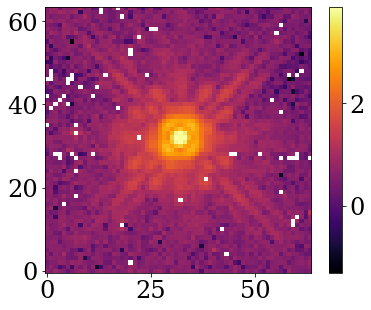

In [79]:
plt.imshow(np.log10(exposures[0].data/exposures[0].err))
plt.colorbar()

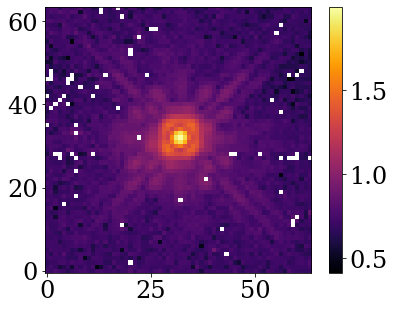

In [80]:
plt.imshow(exposures[0].data**0.125)
plt.colorbar()

In [81]:
params = {
    "fluxes": {},
    "positions": {},
    "slope": {},
    "aberrations": {},
    #"breathing": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.
}

for exp in exposures:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.log10(np.nansum(exp.data))
    params["slope"][exp.fit.get_key(exp, "slope")] = np.zeros(5)#.at[0].set(1)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    #params["breathing"][exp.fit.get_key(exp, "breathing")] = np.zeros(19) + 0.1
    #params["start_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)#jr.uniform(jr.key(0), (8,),minval=-4e-8, maxval=4e-8) #np.asarray([-8.59023084e-10,  1.77049982e-09, -4.45293089e-09, -3.70890613e-08,2.03658617e-08,  1.08092528e-08, -2.77077727e-09,  1.86458672e-09])*0.9#jr.uniform(jr.key(0), (8,),minval=-2e-8, maxval=2e-8)#np.zeros(8)#np.ones(8)*1e-8
    #params["end_aberrations"][exp.fit.get_key(exp, "start_aberrations")] = np.zeros(19)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([0.06, 0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model = set_array(NICMOSModel(exposures, params, optics, detector))

params = ModelParams(params)

In [82]:
params

ModelParams(
  params={
    'fluxes':
    {'F110W': f64[]},
    'positions':
    {'n8yj53vfq': f64[2]},
    'slope':
    {'F110W': f64[5]},
    'aberrations':
    {'n8yj53vfq': f64[26]},
    'cold_mask_shift':
    {'F110W': f64[2]},
    'cold_mask_rot':
    {'F110W': -45.0},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_shear':
    {'F110W': f64[2]},
    'outer_radius':
    1.146,
    'secondary_radius':
    0.44639999999999996,
    'spider_width':
    0.0924,
    'scale':
    0.0432,
    'rot':
    0.0,
    'softening':
    2.0
  }
)

In [83]:
print(params.params)

{'fluxes': {'F110W': Array(3.46182172, dtype=float64)}, 'positions': {'n8yj53vfq': Array([0., 0.], dtype=float64)}, 'slope': {'F110W': Array([0., 0., 0., 0., 0.], dtype=float64)}, 'aberrations': {'n8yj53vfq': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)}, 'cold_mask_shift': {'F110W': Array([6., 6.], dtype=float64)}, 'cold_mask_rot': {'F110W': -45.0}, 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float64)}, 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float64)}, 'primary_scale': {'F110W': Array([1., 1.], dtype=float64)}, 'primary_rot': {'F110W': -45.0}, 'primary_shear': {'F110W': Array([0., 0.], dtype=float64)}, 'outer_radius': 1.146, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924, 'scale': 0.0432, 'rot': 0.0, 'softening': 2.0}


In [84]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 1e-2

things = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*3, 0),
    "cold_mask_shift": opt(g*100, 120),
    "cold_mask_rot": opt(g*100, 120),
    "cold_mask_scale": opt(g*1000, 150),
    "cold_mask_shear": opt(g*10, 150),
    "primary_scale": opt(g*100, 150),
    "primary_rot": opt(g*100, 150),
    "primary_shear": opt(g*100, 150),
    "aberrations": opt(g*1,120),
    "slope": opt(g*20, 50),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [85]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths)
def loss_fn(params,exposures):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [86]:
rc = False
fishers = calc_fishers(model, exposures, paths, recalculate=rc)
lrs = calc_lrs(model, exposures, fishers, paths)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [91]:
fishers

{'n8yj53vfq': {'fluxes': Array([[3.08780591e+09]], dtype=float64),
  'positions': Array([[ 2.89388180e+08, -1.24386821e+07],
         [-1.24386821e+07,  2.83020976e+08]], dtype=float64),
  'cold_mask_shift': Array([[-3293261.97253197,   370926.69496358],
         [  370926.69496358, -3292018.60384012]], dtype=float64),
  'cold_mask_rot': Array([[-5971347.46178022]], dtype=float64),
  'cold_mask_scale': Array([[-1.83108360e+10,  2.35971831e+08],
         [ 2.35971831e+08, -1.82981810e+10]], dtype=float64),
  'cold_mask_shear': Array([[-2913486.2454851 ,    85000.48985465],
         [   85000.48985465, -2913031.7001945 ]], dtype=float64),
  'primary_scale': Array([[1.08223868e+09, 4.90306276e+09],
         [4.90306276e+09, 1.39295102e+09]], dtype=float64),
  'primary_rot': Array([[-4770300.2900512]], dtype=float64),
  'primary_shear': Array([[-896771.65578155, 1496833.25799373],
         [1496833.25799373, -896696.28025277]], dtype=float64),
  'aberrations': Array([[-2.96920117e+03, -1.2

In [87]:
lrs.params

{'aberrations': {'n8yj53vfq': Array([ 0.00033679,  0.00019306,  0.00017359,  0.00237247,  0.00190921,
         -0.00132523, -0.00147616,  0.00049458,  0.00017694,  0.00021189,
          0.00023146,  0.00019979,  0.00041381,  0.00043083,  0.00042289,
          0.00043396,  0.0002786 ,  0.00027801,  0.00019249,  0.00017881,
          0.00014596,  0.00013749,  0.00016108,  0.00023823,  0.00020322,
          0.00024546], dtype=float64)},
 'cold_mask_rot': {'F110W': Array(1.6746639e-07, dtype=float64)},
 'cold_mask_scale': {'F110W': Array([5.46124710e-11, 5.46502409e-11], dtype=float64)},
 'cold_mask_shear': {'F110W': Array([3.43231413e-07, 3.43284970e-07], dtype=float64)},
 'cold_mask_shift': {'F110W': Array([3.03650304e-07, 3.03764991e-07], dtype=float64)},
 'fluxes': {'F110W': Array(-3.23854552e-10, dtype=float64)},
 'outer_radius': None,
 'positions': {'n8yj53vfq': Array([-3.45556615e-09, -3.53330702e-09], dtype=float64)},
 'primary_rot': {'F110W': Array(2.09630409e-07, dtype=float64)},

In [88]:
model

NICMOSModel(
  params={
    'aberrations':
    {'n8yj53vfq': f64[26]},
    'cold_mask_rot':
    {'F110W': f64[]},
    'cold_mask_scale':
    {'F110W': f64[2]},
    'cold_mask_shear':
    {'F110W': f64[2]},
    'cold_mask_shift':
    {'F110W': f64[2]},
    'fluxes':
    {'F110W': f64[]},
    'outer_radius':
    f64[],
    'positions':
    {'n8yj53vfq': f64[2]},
    'primary_rot':
    {'F110W': f64[]},
    'primary_scale':
    {'F110W': f64[2]},
    'primary_shear':
    {'F110W': f64[2]},
    'rot':
    f64[],
    'scale':
    f64[],
    'secondary_radius':
    f64[],
    'slope':
    {'F110W': f64[5]},
    'softening':
    f64[],
    'spider_width':
    f64[]
  },
  filters={'F110W': f64[15,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f64[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=CoordTransform(
          translation=None,
          rotation=f64[],
          compression=None,
          shear=None
    

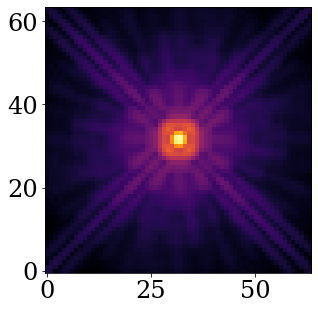

In [89]:
plt.imshow(exposures[0].fit(model,exposures[0])**0.125)

In [90]:
optim, opt_state = zdx.get_optimiser(
    params, groups, optimisers
)


losses, models = [], []
for i in tqdm(range(600)):
    loss, grads = loss_fn(params,exposures)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
    updates, opt_state = optim.update(grads, opt_state)
    params = zdx.apply_updates(params, updates)
    
    if i == 200:
        params.set("softening", 0.2)

    models.append(params)
    losses.append(loss)


  0%|          | 0/600 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#model


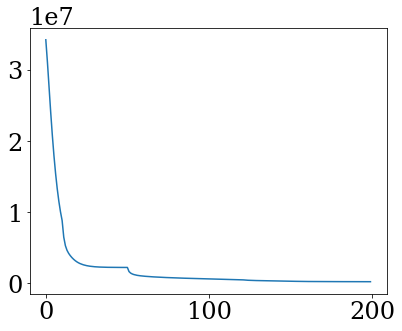

In [ ]:
plt.plot(losses[:])

11


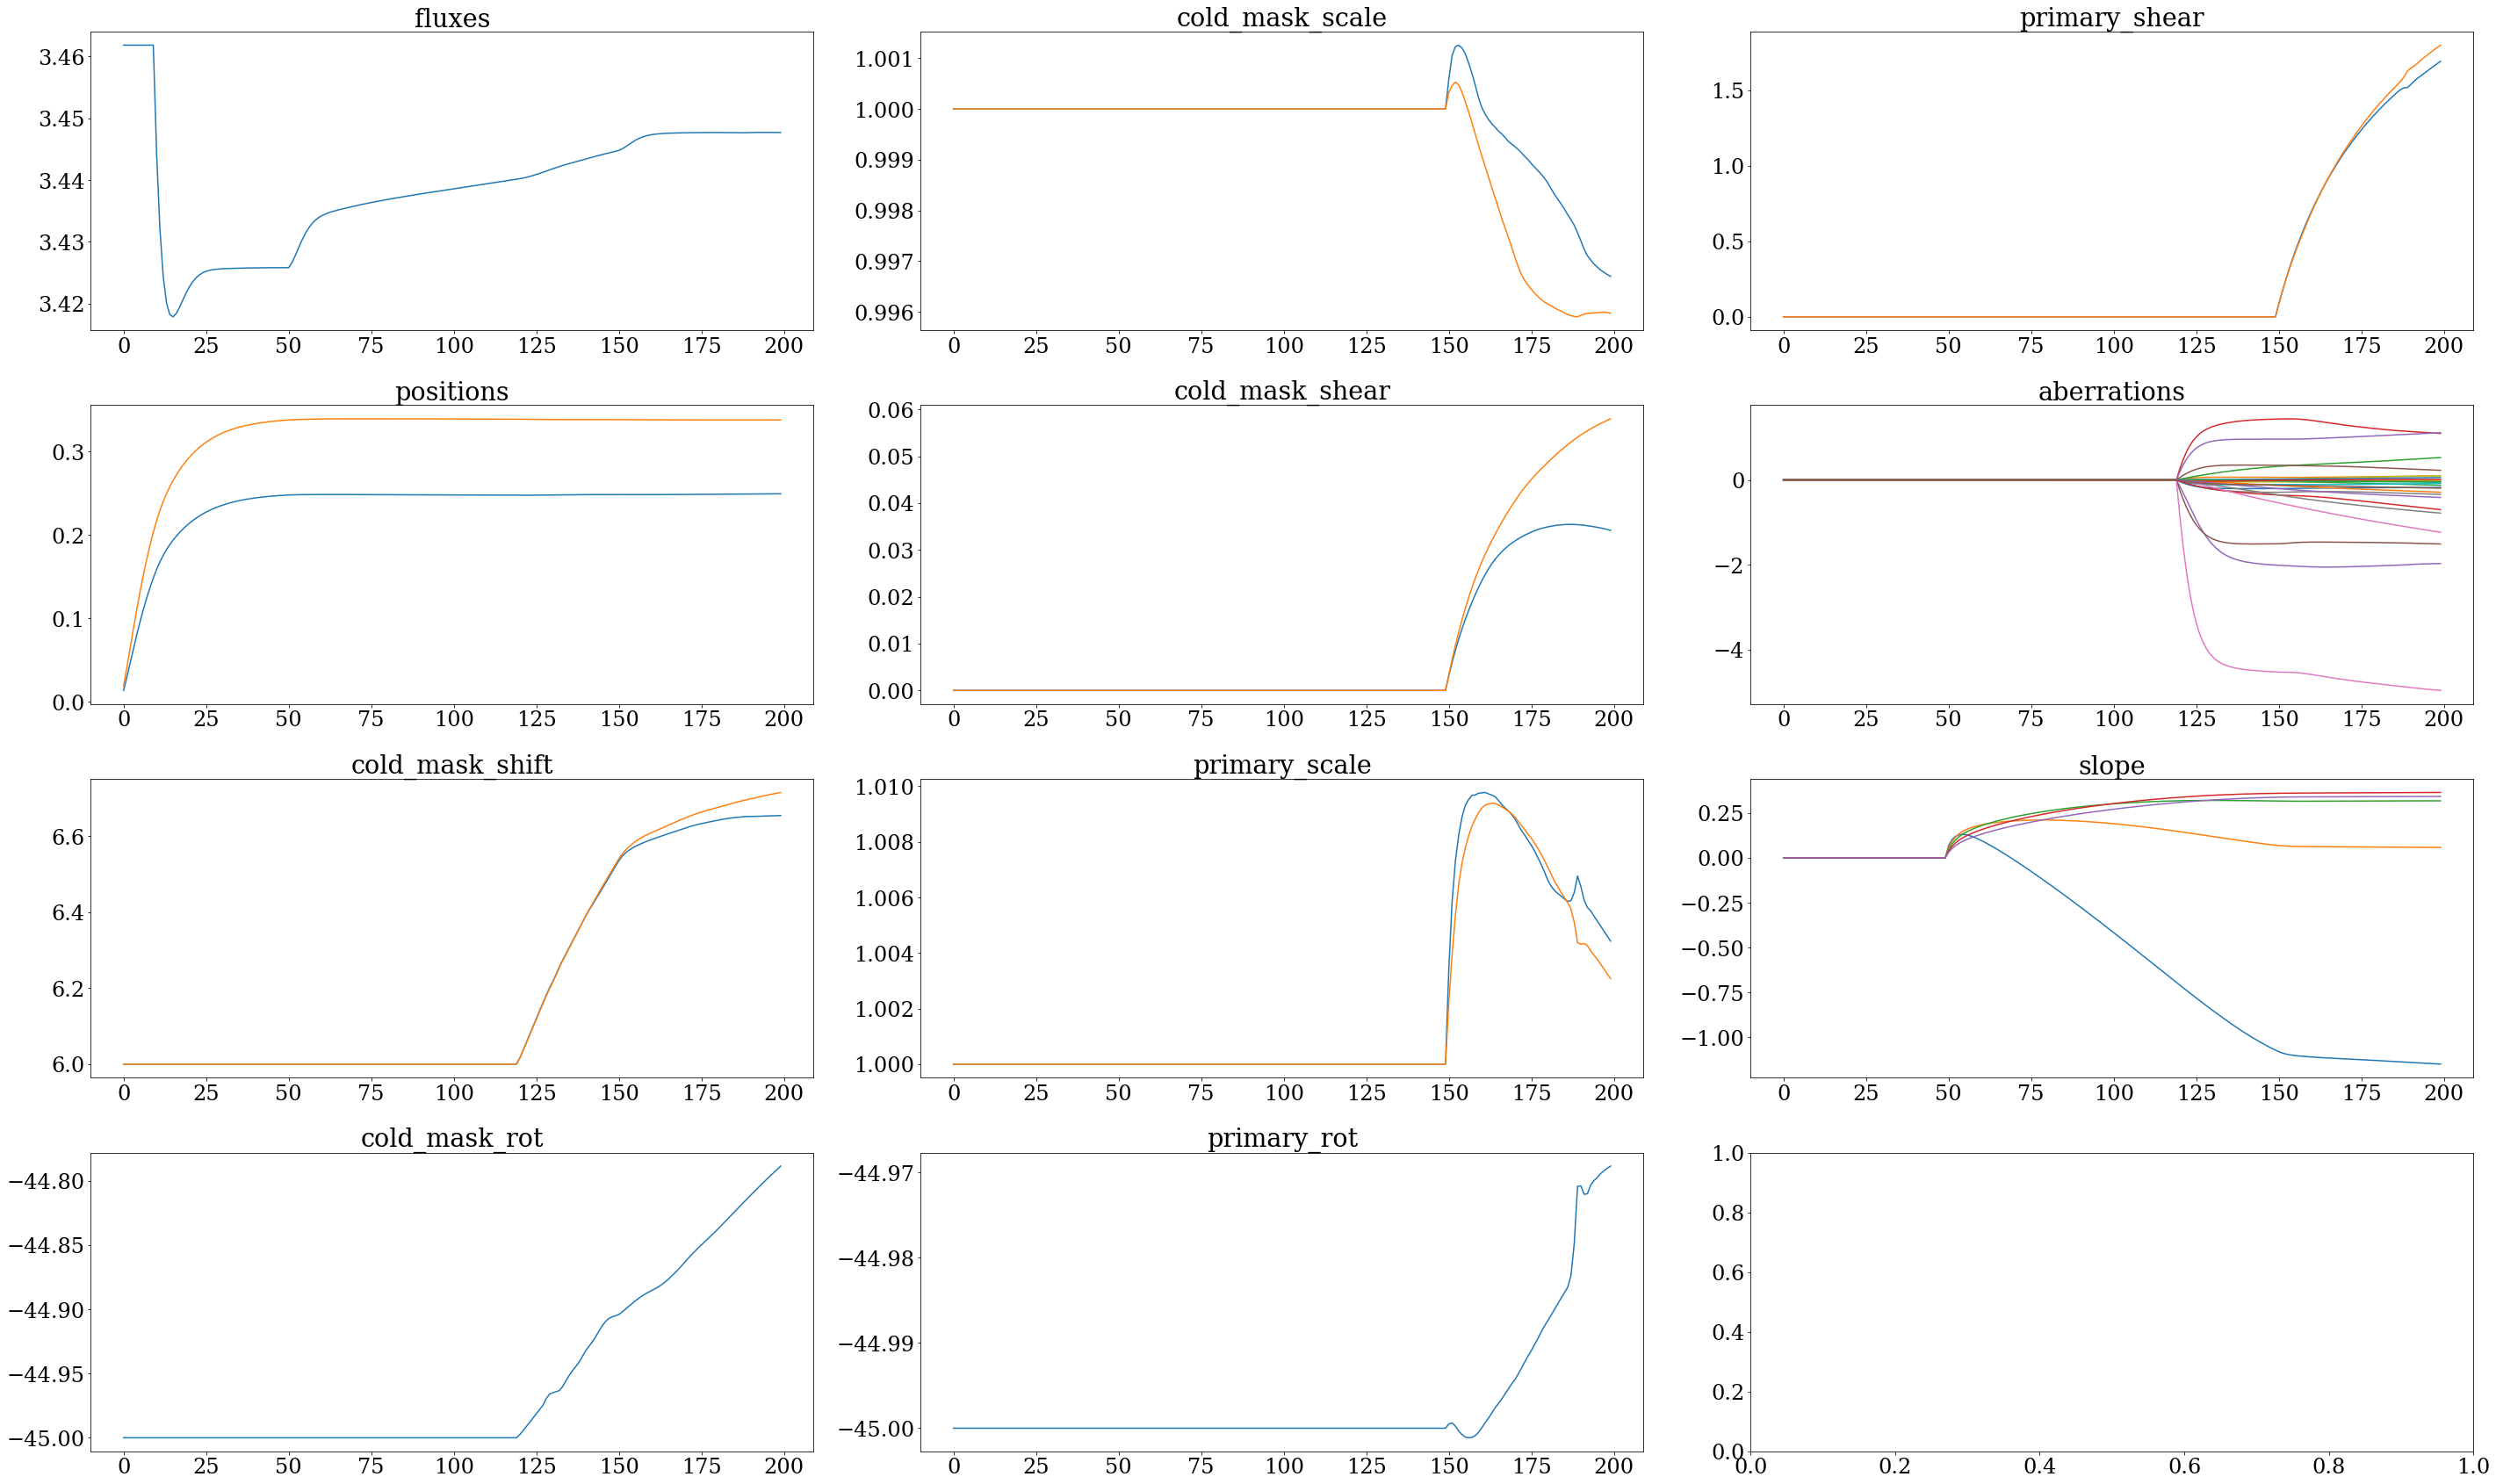

In [ ]:
xw = 4
yw = int(np.ceil(len(groups)/xw))

print(len(groups))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", 
                 "cold_mask_shift", "cold_mask_rot", "cold_mask_scale", "cold_mask_shear",
                 "primary_rot","primary_scale", "primary_shear", "breathing", "slope"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        #print(injected_params[param])
        """for j in injected_params[param].values():
            print(j)
            print(len(j.shape))
            if len(j.shape)>0:
                for k in j:
                    sp.axhline(k, color='k', linestyle='--')
            else:
                sp.axhline(j, color='k', linestyle='--')"""
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models])
        #sp.axhline(injected_params[param], color='k', linestyle='--')

    
fig.tight_layout()

In [ ]:
#for exp in exposures:
#    params = params.set("aberrations."+exp.fit.get_key(exp, "aberrations"), -params.get("aberrations."+exp.fit.get_key(exp, "aberrations")))

3.422592e+07, 2.289896e+05


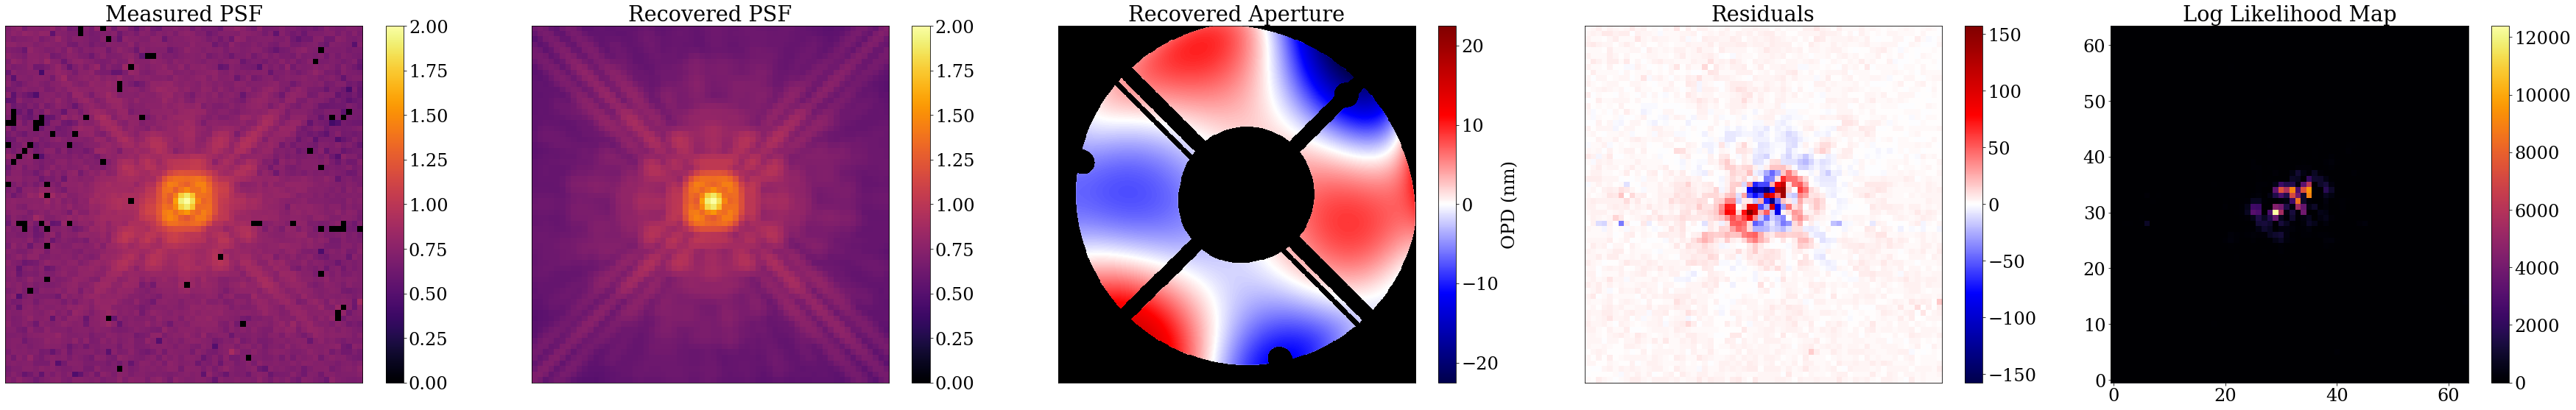

In [ ]:
print(f"{float(losses[0]):e}, {float(losses[-1]):e}")

fig, axs = plt.subplots(1,5, figsize=(50,8))

fig.tight_layout()

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

#vm = max(np.max(cropped_data),np.max(telescope.model()))

exp = exposures[0]


model = params.inject(model)

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exp.data**0.125
telescope_frame = exp.fit(model,exp)**0.125

vm = max(np.nanmax(cropped_frame),np.nanmax(telescope_frame))
cd=axs[0].imshow(cropped_frame, vmin=0,vmax=vm,cmap=cmap)
plt.colorbar(cd,ax=axs[0])
tl=axs[1].imshow(telescope_frame, vmin=0, vmax=vm,cmap=cmap)
plt.colorbar(tl,ax=axs[1])
#axs[2].imshow(cropped_err)
cmap = matplotlib.colormaps['seismic']
cmap.set_bad('k',1)

#start_aberrations = model.get(exp.fit.map_param(exp, "start_aberrations"))#*1e-9
#end_aberrations = model.get(exp.fit.map_param(exp, "end_aberrations"))#*1e-9

#aberrations_model = model.set(exp.map_param("aberrations"), (start_aberrations+end_aberrations)/2)

optics = exp.fit.update_optics(model, exp)

support = optics.transmission(coords,2.4/512)
support_mask = support.at[support < .5].set(np.nan)

opd = optics.AberratedAperture.eval_basis(coords)*1e9
olim = np.max(np.abs(opd))
apt =axs[2].imshow(support_mask*opd,cmap=cmap,vmin=-olim, vmax=olim)
plt.colorbar(apt, ax=axs[2]).set_label("OPD (nm)")
#axs[4].imshow(telescope.detector.pixel_response.pixel_response)
resid = (exp.data - exp.fit(model,exp))/exp.err
rlim = np.nanmax(np.abs(resid))
resid=axs[3].imshow(resid, cmap='seismic',vmin=-rlim, vmax=rlim)
plt.colorbar(resid,ax=axs[3])

lpdf = posterior(model,exp,return_im=True)#*nanmap
lpd = axs[4].imshow(lpdf)
plt.colorbar(lpd, ax=axs[4])

axs[0].set_title("Measured PSF")
axs[1].set_title("Recovered PSF")
axs[2].set_title("Recovered Aperture")
axs[3].set_title("Residuals")
axs[4].set_title("Log Likelihood Map")

for i in range(4):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

#axs[1].imshow(telescope.optics.aberrations.eval_basis(coords)*1e9)
plt.show()
#plt.imshow(np.abs(telescope.model()-cropped_data)**0.25)


In [ ]:
params.aberrations

{'n8yj53vfq': Array([-5.32326407e-02,  1.99731311e-03, -1.25097098e-01,  1.09761846e+00,
        -1.97175793e+00, -1.51013323e+00, -4.96653325e+00, -3.40200190e-01,
        -1.03433069e-02, -8.13640358e-02, -1.75389069e-01,  9.78020947e-02,
         5.29626896e-01, -7.00025073e-01,  1.11485180e+00,  2.27398291e-01,
        -1.23406221e+00, -7.82244008e-01,  1.00025873e-01, -4.78385241e-02,
         5.64497540e-02, -2.88318783e-01, -4.28464920e-02,  8.87642161e-03,
        -4.13068114e-01, -1.93772504e-01], dtype=float64)}

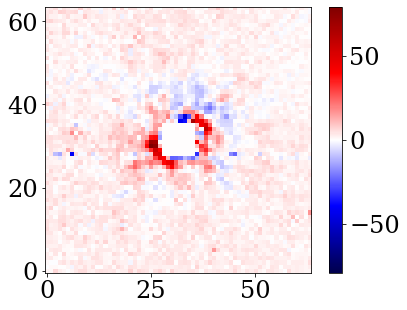

In [ ]:
resid = (exp.data - exp.fit(model,exp))/exp.err

bresid = resid.at[28:36, 28:36].set(0)
vm = np.nanmax(np.abs(bresid))
plt.imshow(bresid, cmap='seismic', vmin=-vm, vmax=vm)

#print(np.nanmedian(np.abs(resid[50:-50,50:-50])))
#plt.imshow((np.abs(resid[50:-50,50:-50])))
plt.colorbar()